In [37]:
using LinearAlgebra
using Random
using Makie, GLMakie
Makie.inline!(true)

true

In [298]:
function make_problem(; seed=123)
    Random.seed!(seed)

    dt = 0.1
    ax = 0.0
    ay = 0.0
    vx = 0.0
    vy = 0.0
    x = 0.0
    y = 0.0
    p0 = (x=x, y=y)
    
    path = []
    states = []
    for t = 0:dt:10
        if t > 0
            ax = 0.4 * ax + 0.3 * randn()
            ay = 0.4 * ax + 0.3 * randn()
            vx += ax * dt
            vy += ay * dt
            x += vx * dt + 1/2 * dt^2 * ax
            y += vy * dt + 1/2 * dt^2 * ay
        end
        push!(path, Point(x, y))
        push!(states, (ax=ax, ay=ay, vx=vx, vy=vy))
    end
    path, states
end

path, states = make_problem(seed=123)

(Any[Point{Float64}(0.0, 0.0), Point{Float64}(-0.002905788024467896, -0.007746946414787305), Point{Float64}(-0.013311512105704347, -0.01727848316447461), Point{Float64}(-0.022066699401905778, -0.021408898385413915), Point{Float64}(-0.030540234781108205, -0.01992706206904728), Point{Float64}(-0.04505828622174312, -0.021331991650744474), Point{Float64}(-0.057312341979081804, -0.02590740554543851), Point{Float64}(-0.06989335129981943, -0.03240804006873883), Point{Float64}(-0.07939911844836138, -0.03723381894796556), Point{Float64}(-0.08777804153576968, -0.04601522682286642)  …  Point{Float64}(1.4825319973796114, -0.6665878160334364), Point{Float64}(1.5313124399142515, -0.7053690302846662), Point{Float64}(1.583445288173648, -0.7384253159459759), Point{Float64}(1.6320311828134395, -0.7717696087600775), Point{Float64}(1.6792942515898786, -0.8060579519884461), Point{Float64}(1.7262345359258746, -0.8449121636652953), Point{Float64}(1.7761989772257383, -0.8858843824011766), Point{Float64}(1.830

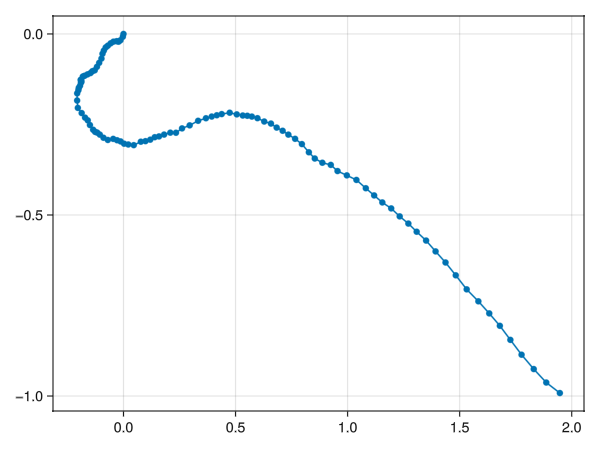

In [299]:
x = getproperty.(path, :x)
y = getproperty.(path, :y)

scatterlines(x, y)


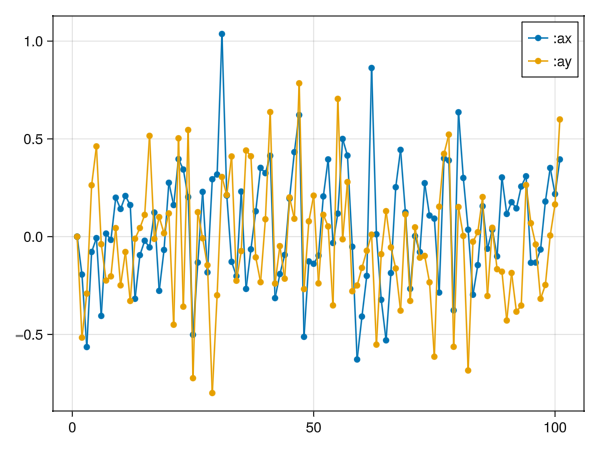

In [65]:
scatterlines(getproperty.(states, :ax), label=":ax")
scatterlines!(getproperty.(states, :ay), label=":ay")
axislegend()
F = current_figure()

In [301]:
function fit(y; F, H, Q, R, n_state_dim)
    if y isa AbstractVector
        y = reshape(y, 1, :)
    end
    N = size(y,2)
    n_obs_dim = size(y,1)

    @assert size(H,2) == n_state_dim
    @assert size(H,1) == n_obs_dim
    @assert size(R,1) == size(R,2) == n_obs_dim

    x = zeros(n_state_dim, N)
    V = zeros(n_state_dim, n_state_dim, N)
    K = zeros(n_state_dim, n_obs_dim, N)
    x̂ = zeros(n_state_dim, N)
    V̂ = zeros(n_state_dim, n_state_dim, N)

    V̂[:,:,1] = 1000 * diagm(ones(n_state_dim))

    for k = axes(y,2)
        @views _filter!(x[:,k], V[:,:,k], x̂[:,k], V̂[:,:,k], K[:,:,k], y[:,k], H, R)
        if k < size(y,2)
            @views _next!(x̂[:,k+1], V̂[:,:,k+1], x[:,k], V[:,:,k], F, Q)
        end
    end
    (; x, V, x̂, V̂, K)
end

"""

"""
function _filter!(x, V, x̂, V̂, K, y, H, R)
    K .= V̂ * H' * (H * V̂ * H' .+ R)
    x .= (x̂ + K * (y .- H *x̂))
    V .= (I - K * H) * V̂
    return
end

function _next!(x̂, V̂, x, V, F, Q)
    x̂ .= F * x
    V̂ .= F * V̂ * F' + Q
end

let 
    H = [1. 0.]
    x = randn(2)
    V = diagm(ones(2))
    K = ones(2,1)
    R = ones(1,1)
    y = ones(1)
    F = [1. 0.; 0. 1.]
    Q = diagm(ones(2))
    _filter!(x, V, x, V, K, y, H, R)

    _next!(x, V, x ,V, F, Q)
end

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  2.0

In [302]:
y = hcat([[p...] for p in zip(
    getproperty.(states, :ax),
    getproperty.(states, :ay),
)]...)

dt = 0.1
F = [
    1. 0. dt 0. 1/2 * dt^2 0.;
    0. 1. 0. dt    0. 1/2 * dt^2;
    0. 0. 1. 0. dt 0.;
    0. 0. 0. 1. 0. dt;
    0. 0. 0. 0. 1. 0.;
    0. 0. 0. 0. 0. 1.;
]

H = [
    0. 0. 0. 0. 1. 0.;
    0. 0. 0. 0. 0. 1.;
]


R = 1e-12 * diagm(ones(2))
Q = 1.0 * diagm([0., 0., 0., 0., 1.0, 1.0])

results = fit(y, F=F, H=H, R=R, Q=Q, n_state_dim=6)
results.x̂


6×101 Matrix{Float64}:
 0.0  0.0  -0.000968596  -0.00572863  …   1.72713    1.77796      1.83163
 0.0  0.0  -0.00258232   -0.00920258     -0.846148  -0.885855    -0.92471
 0.0  0.0  -0.0193719    -0.0758288       0.49066    0.525798     0.547604
 0.0  0.0  -0.0516463    -0.080759       -0.397367  -0.396783    -0.380318
 0.0  0.0  -0.193719     -0.564569        0.179696   0.351381     0.218061
 0.0  0.0  -0.516463     -0.291127    …  -0.247107   0.00583862   0.164649

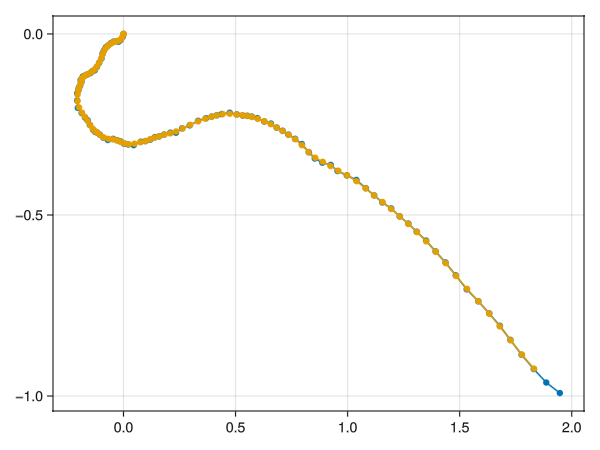

In [303]:
positions = hcat(getproperty.(path, :x), getproperty.(path, :y)) |> transpose

scatterlines(positions[1,:], positions[2,:])
scatterlines!(results.x̂[1,:], results.x̂[2,:])
current_figure()

In [310]:
y

2×101 Matrix{Float64}:
 0.0  -0.193719  -0.564569  -0.0781538  …  0.351381    0.218061  0.394998
 0.0  -0.516463  -0.291127   0.263032      0.00583862  0.164649  0.599577

In [308]:
results.x

6×101 Matrix{Float64}:
 0.0   0.0       -0.000968596  …   1.72713      1.77796    1.83163
 0.0   0.0       -0.00258232      -0.846148    -0.885855  -0.92471
 0.0   0.0       -0.0193719        0.49066      0.525798   0.547604
 0.0   0.0       -0.0516463       -0.397367    -0.396783  -0.380318
 0.0  -0.193719  -0.564569         0.351381     0.218061   0.394998
 0.0  -0.516463  -0.291127     …   0.00583862   0.164649   0.599577